# Problematic Data
* Missing Value
* imbalanced Data
* PCA-based Outlier
* Overfit

In [1]:
# @title
import datetime
print(datetime.datetime.now())

2024-03-28 00:34:34.196442


## Missing Value

* Mean
* Median
* Mode
* Fixed value, e.g., salary
* Nearest neighbor

## Imbalanced Data

* Oversampling: Randomly replicate data from minority class. However, if some data is mislabled, the accuracy might be affected. Also, the distribution changes.
* Undersampling: Randomly delete data from majority class. However, the distribution changes.
* Resampling: Create new data samples by combining several old data smaples.
* We will talk about GAN (Generative Adversarial Network) model later.

Plase take a look at the following website. It provides several advanced methods to deal with imbalanced data.
https://imbalanced-learn.readthedocs.io/en/stable/



### Random Over Sampler

In [2]:
import seaborn as sns

In [3]:
from sklearn.datasets import make_classification

def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=0.8,
    n_clusters=1,
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=0,
    )

In [4]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

In [5]:
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

### SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE is one of the resampling methods. See figure 1 of [this paper](https://www.hindawi.com/journals/ddns/2015/562724/). It generates new data points by using a data in the minority class with its k (k=5 in the figure) neighbors.

### Adaptive Synthetic (ADASYN)

ADASYN is more complex. [Here is the original paper.](https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf)

Its a improved version of Smote. What it does is same as SMOTE just with a minor improvement. After creating those sample it adds a random small values to the points thus making it more realistic. In other words instead of all the sample being linearly correlated to the parent they have a little more variance in them i.e they are bit scattered.




### Different imbalanced data

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

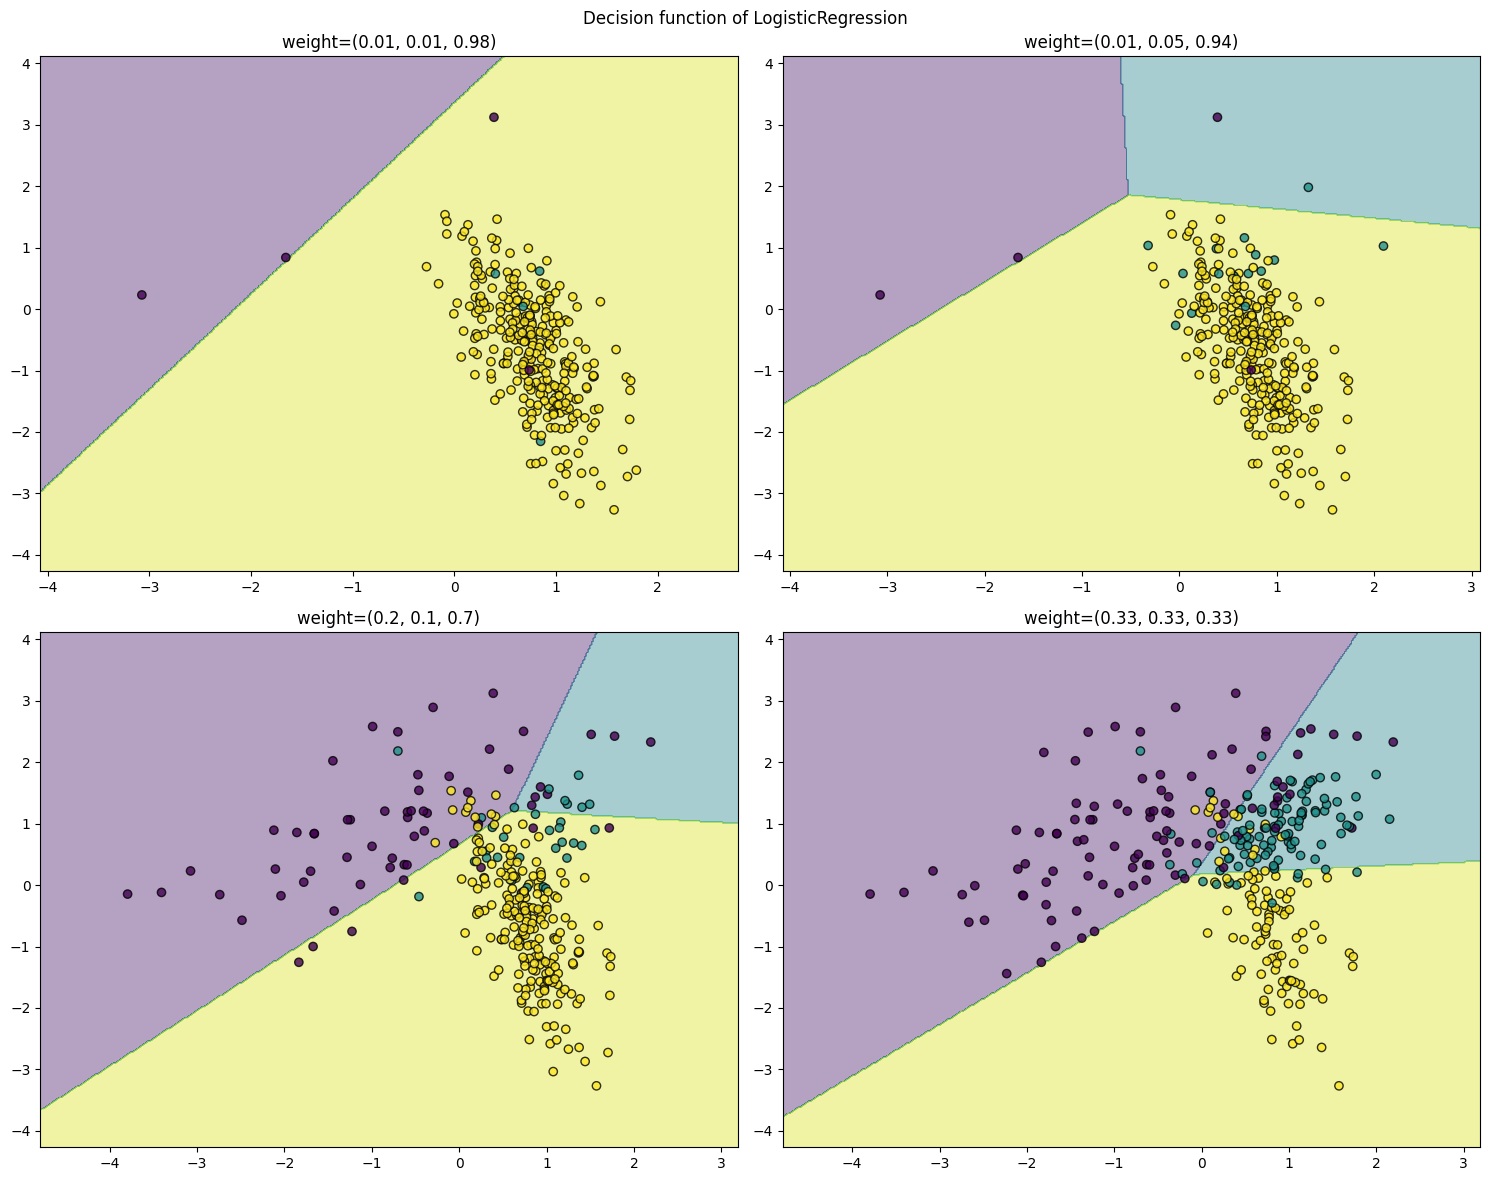

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.01, 0.01, 0.98),
    (0.01, 0.05, 0.94),
    (0.2, 0.1, 0.7),
    (0.33, 0.33, 0.33),
)
for ax, weights in zip(axs.ravel(), weights_arr):
    X, y = create_dataset(n_samples=300, weights=weights)
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax, title=f"weight={weights}")
    fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()

Greater is the difference between the number of samples in each class, poorer are the classification results.

### Random over-sampling to balance the data set


Random over-sampling can be used to repeat some samples and balance the number of samples between the dataset. It can be seen that with this trivial approach the boundary decision is already less biased toward the majority class.

In [9]:
from imblearn.over_sampling import RandomOverSampler

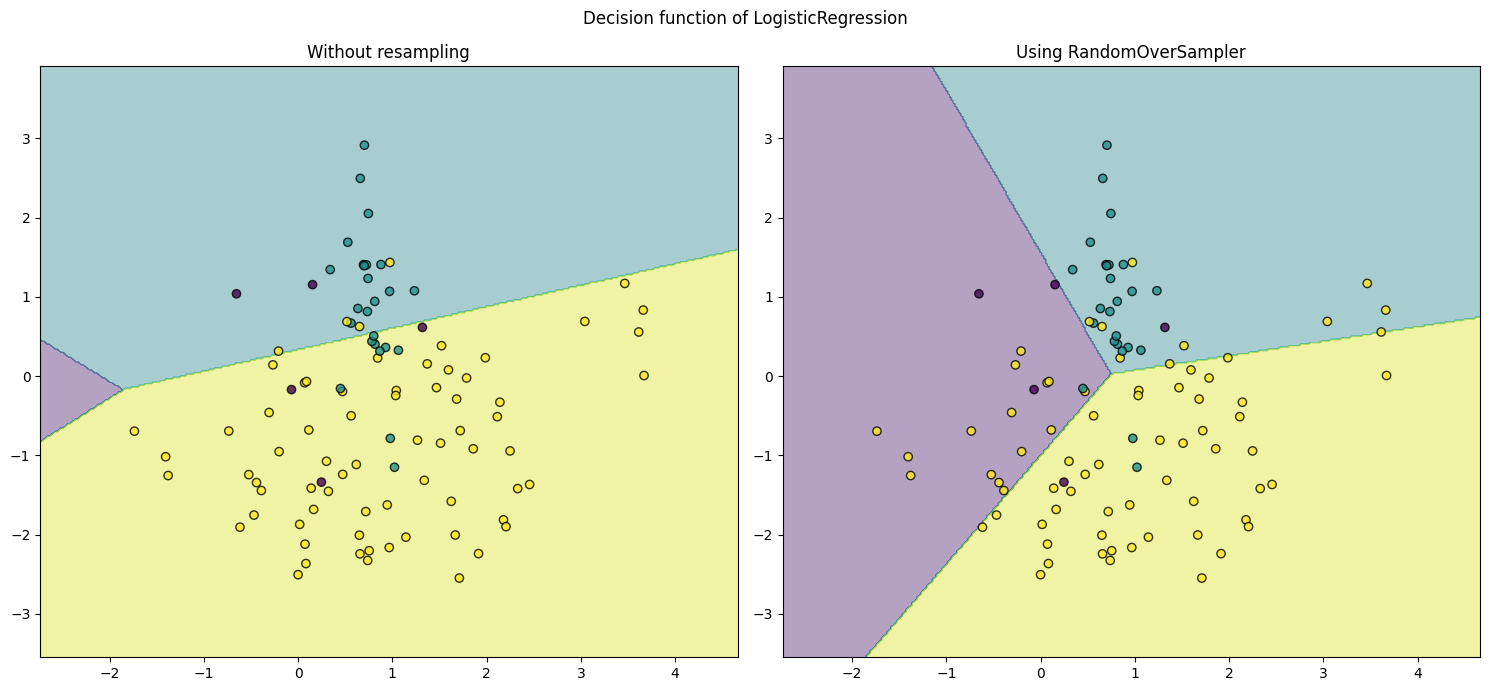

In [10]:
from imblearn.pipeline import make_pipeline

X, y = create_dataset(n_samples=100, weights=(0.05, 0.25, 0.7))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

clf.fit(X, y)
plot_decision_function(X, y, clf, axs[0], title="Without resampling")

sampler = RandomOverSampler(sampling_strategy='auto', random_state=0)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

model = make_pipeline(sampler, clf).fit(X, y)
plot_decision_function(X, y, model, axs[1], f"Using {model[0].__class__.__name__}")

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()

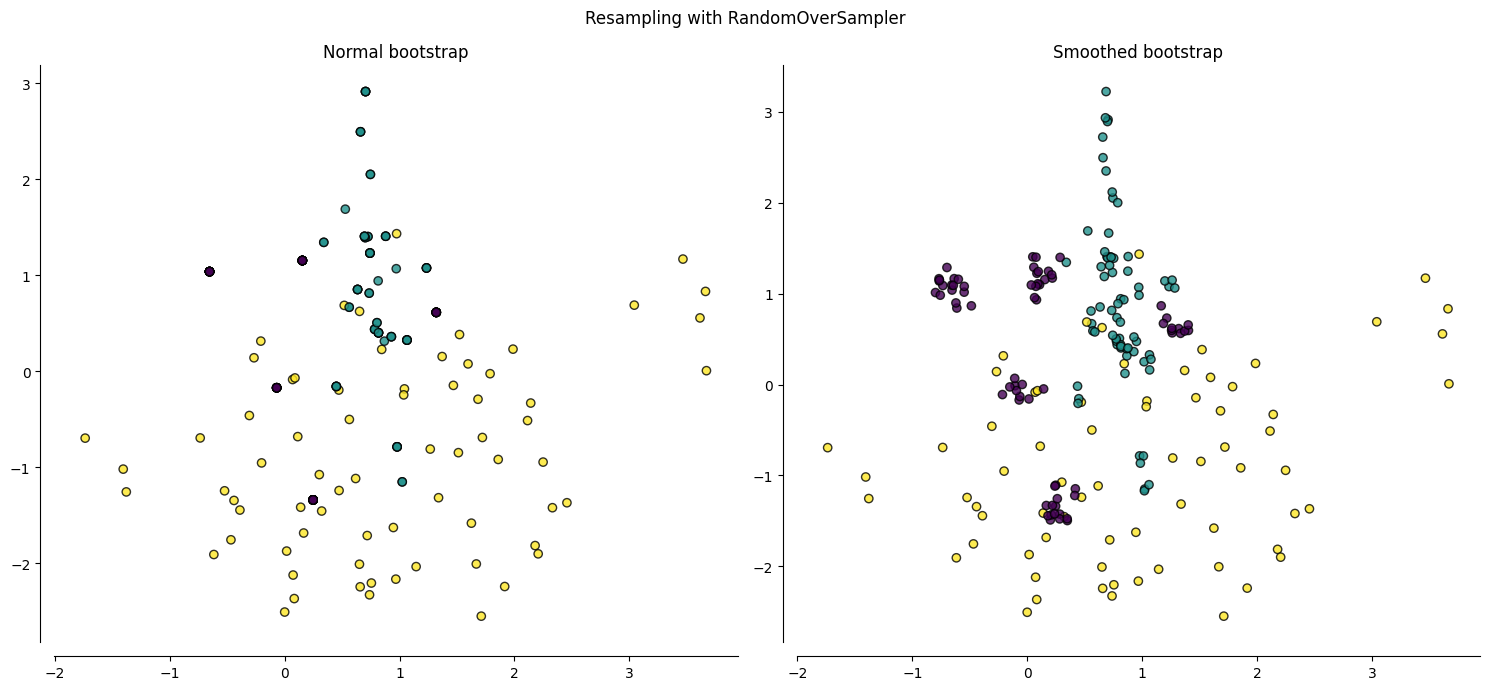

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sampler.set_params(shrinkage=None)
plot_resampling(X, y, sampler, ax=axs[0], title="Normal bootstrap")

sampler.set_params(shrinkage=0.3)
plot_resampling(X, y, sampler, ax=axs[1], title="Smoothed bootstrap")

fig.suptitle(f"Resampling with {sampler.__class__.__name__}")
fig.tight_layout()

### ADASYN and SMOTE

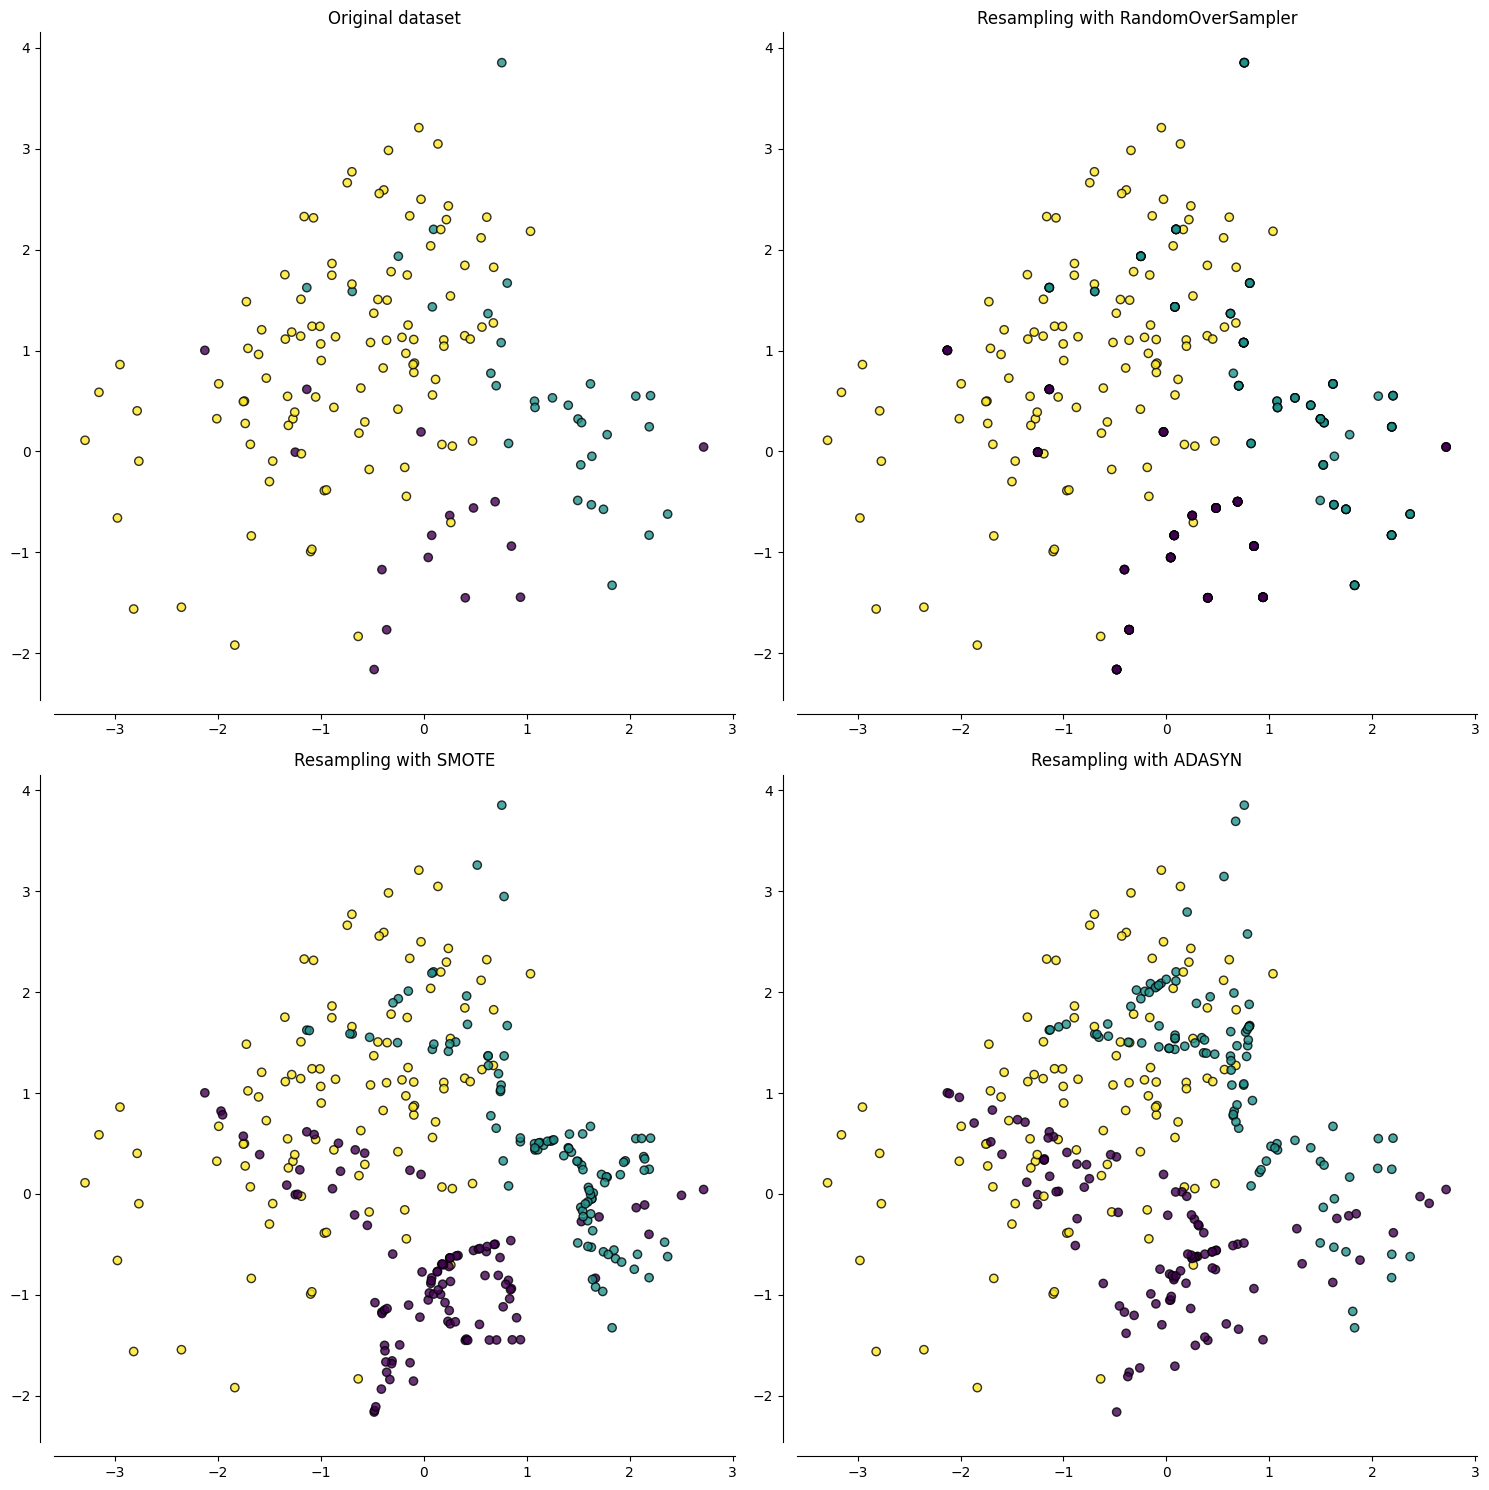

In [12]:
from imblearn import FunctionSampler  # to use a idendity sampler
from imblearn.over_sampling import ADASYN, SMOTE

X, y = create_dataset(n_samples=150, weights=(0.1, 0.2, 0.7))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

samplers = [
    FunctionSampler(),
    RandomOverSampler(random_state=0),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

for ax, sampler in zip(axs.ravel(), samplers):
    title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
    plot_resampling(X, y, sampler, ax, title=title)
fig.tight_layout()

ADASYN will focus on the samples which are difficult to classify with a nearest-neighbors rule while regular SMOTE will not make any distinction.

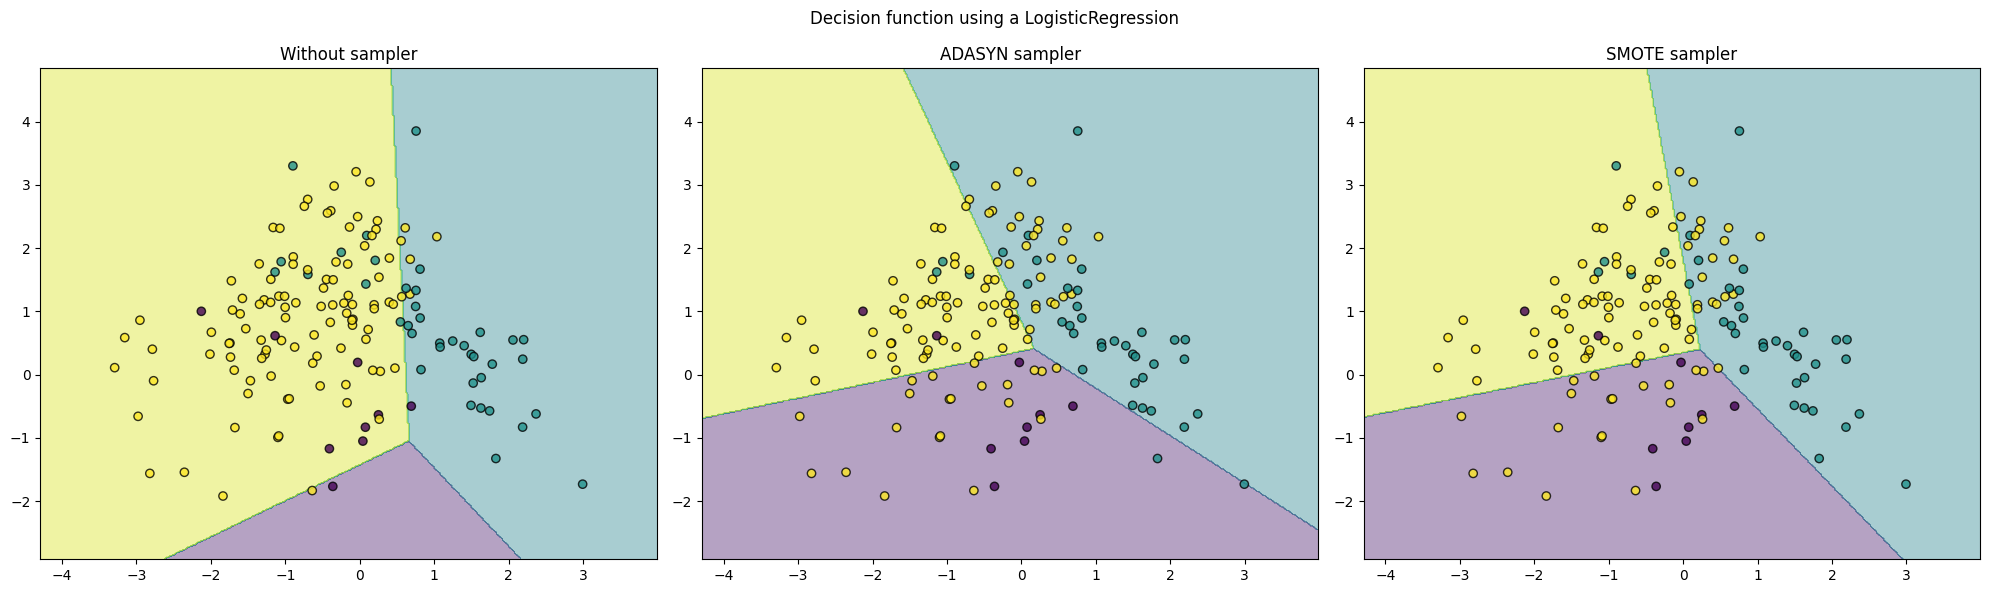

In [13]:
X, y = create_dataset(n_samples=150, weights=(0.05, 0.25, 0.7))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

models = {
    "Without sampler": clf,
    "ADASYN sampler": make_pipeline(ADASYN(random_state=0), clf),
    "SMOTE sampler": make_pipeline(SMOTE(random_state=0), clf),
}

for ax, (title, model) in zip(axs, models.items()):
    model.fit(X, y)
    plot_decision_function(X, y, model, ax=ax, title=title)

fig.suptitle(f"Decision function using a {clf.__class__.__name__}")
fig.tight_layout()

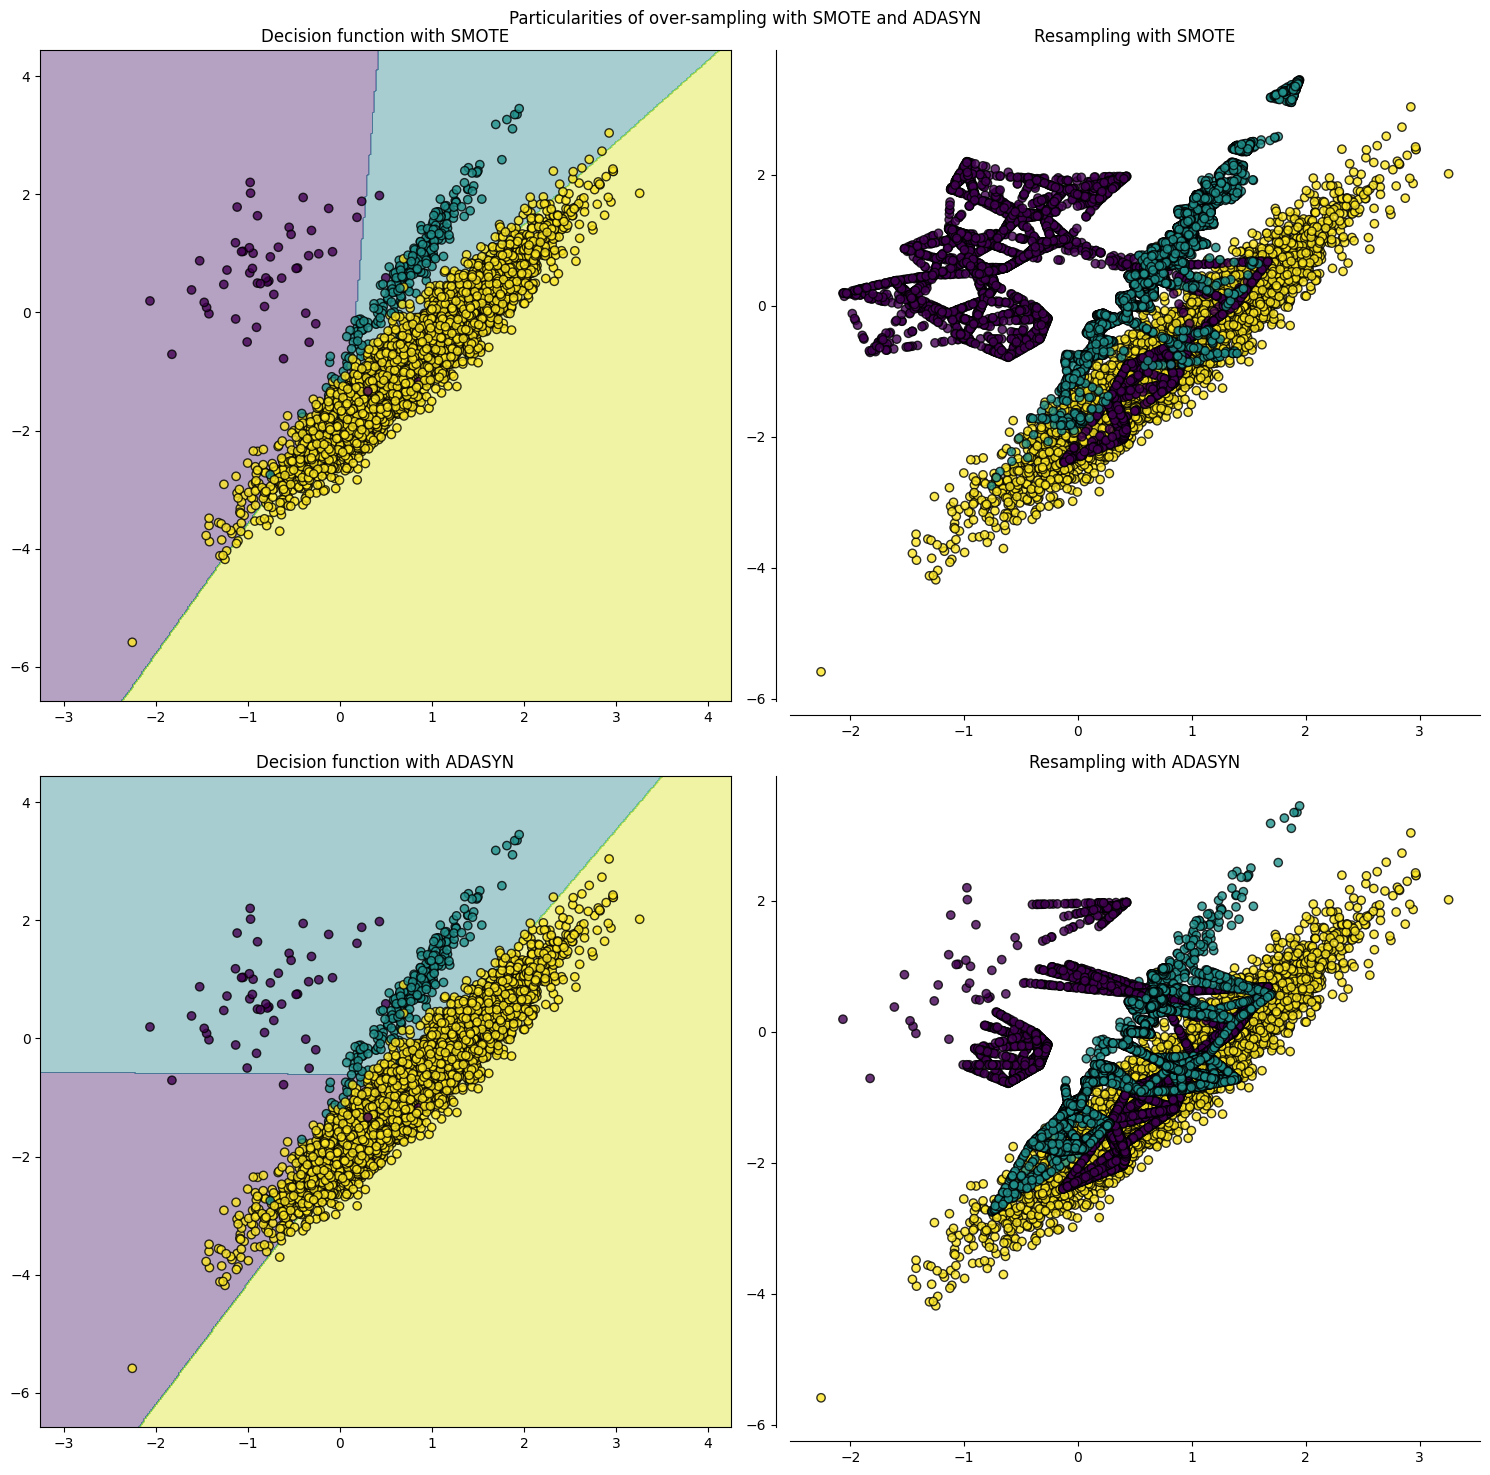

In [14]:
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94), class_sep=0.8)

samplers = [SMOTE(random_state=0), ADASYN(random_state=0)]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for ax, sampler in zip(axs, samplers):
    model = make_pipeline(sampler, clf).fit(X, y)
    plot_decision_function(
        X, y, clf, ax[0], title=f"Decision function with {sampler.__class__.__name__}"
    )
    plot_resampling(X, y, sampler, ax[1])

fig.suptitle("Particularities of over-sampling with SMOTE and ADASYN")
fig.tight_layout()

SMOTE proposes several variants by identifying specific samples to consider during the resampling. The borderline version (BorderlineSMOTE) will detect which point to select which are in the border between two classes. The SVM version (SVMSMOTE) will use the support vectors found using an SVM algorithm to create new sample while the KMeans version (KMeansSMOTE) will make a clustering before to generate samples in each cluster independently depending each cluster density.

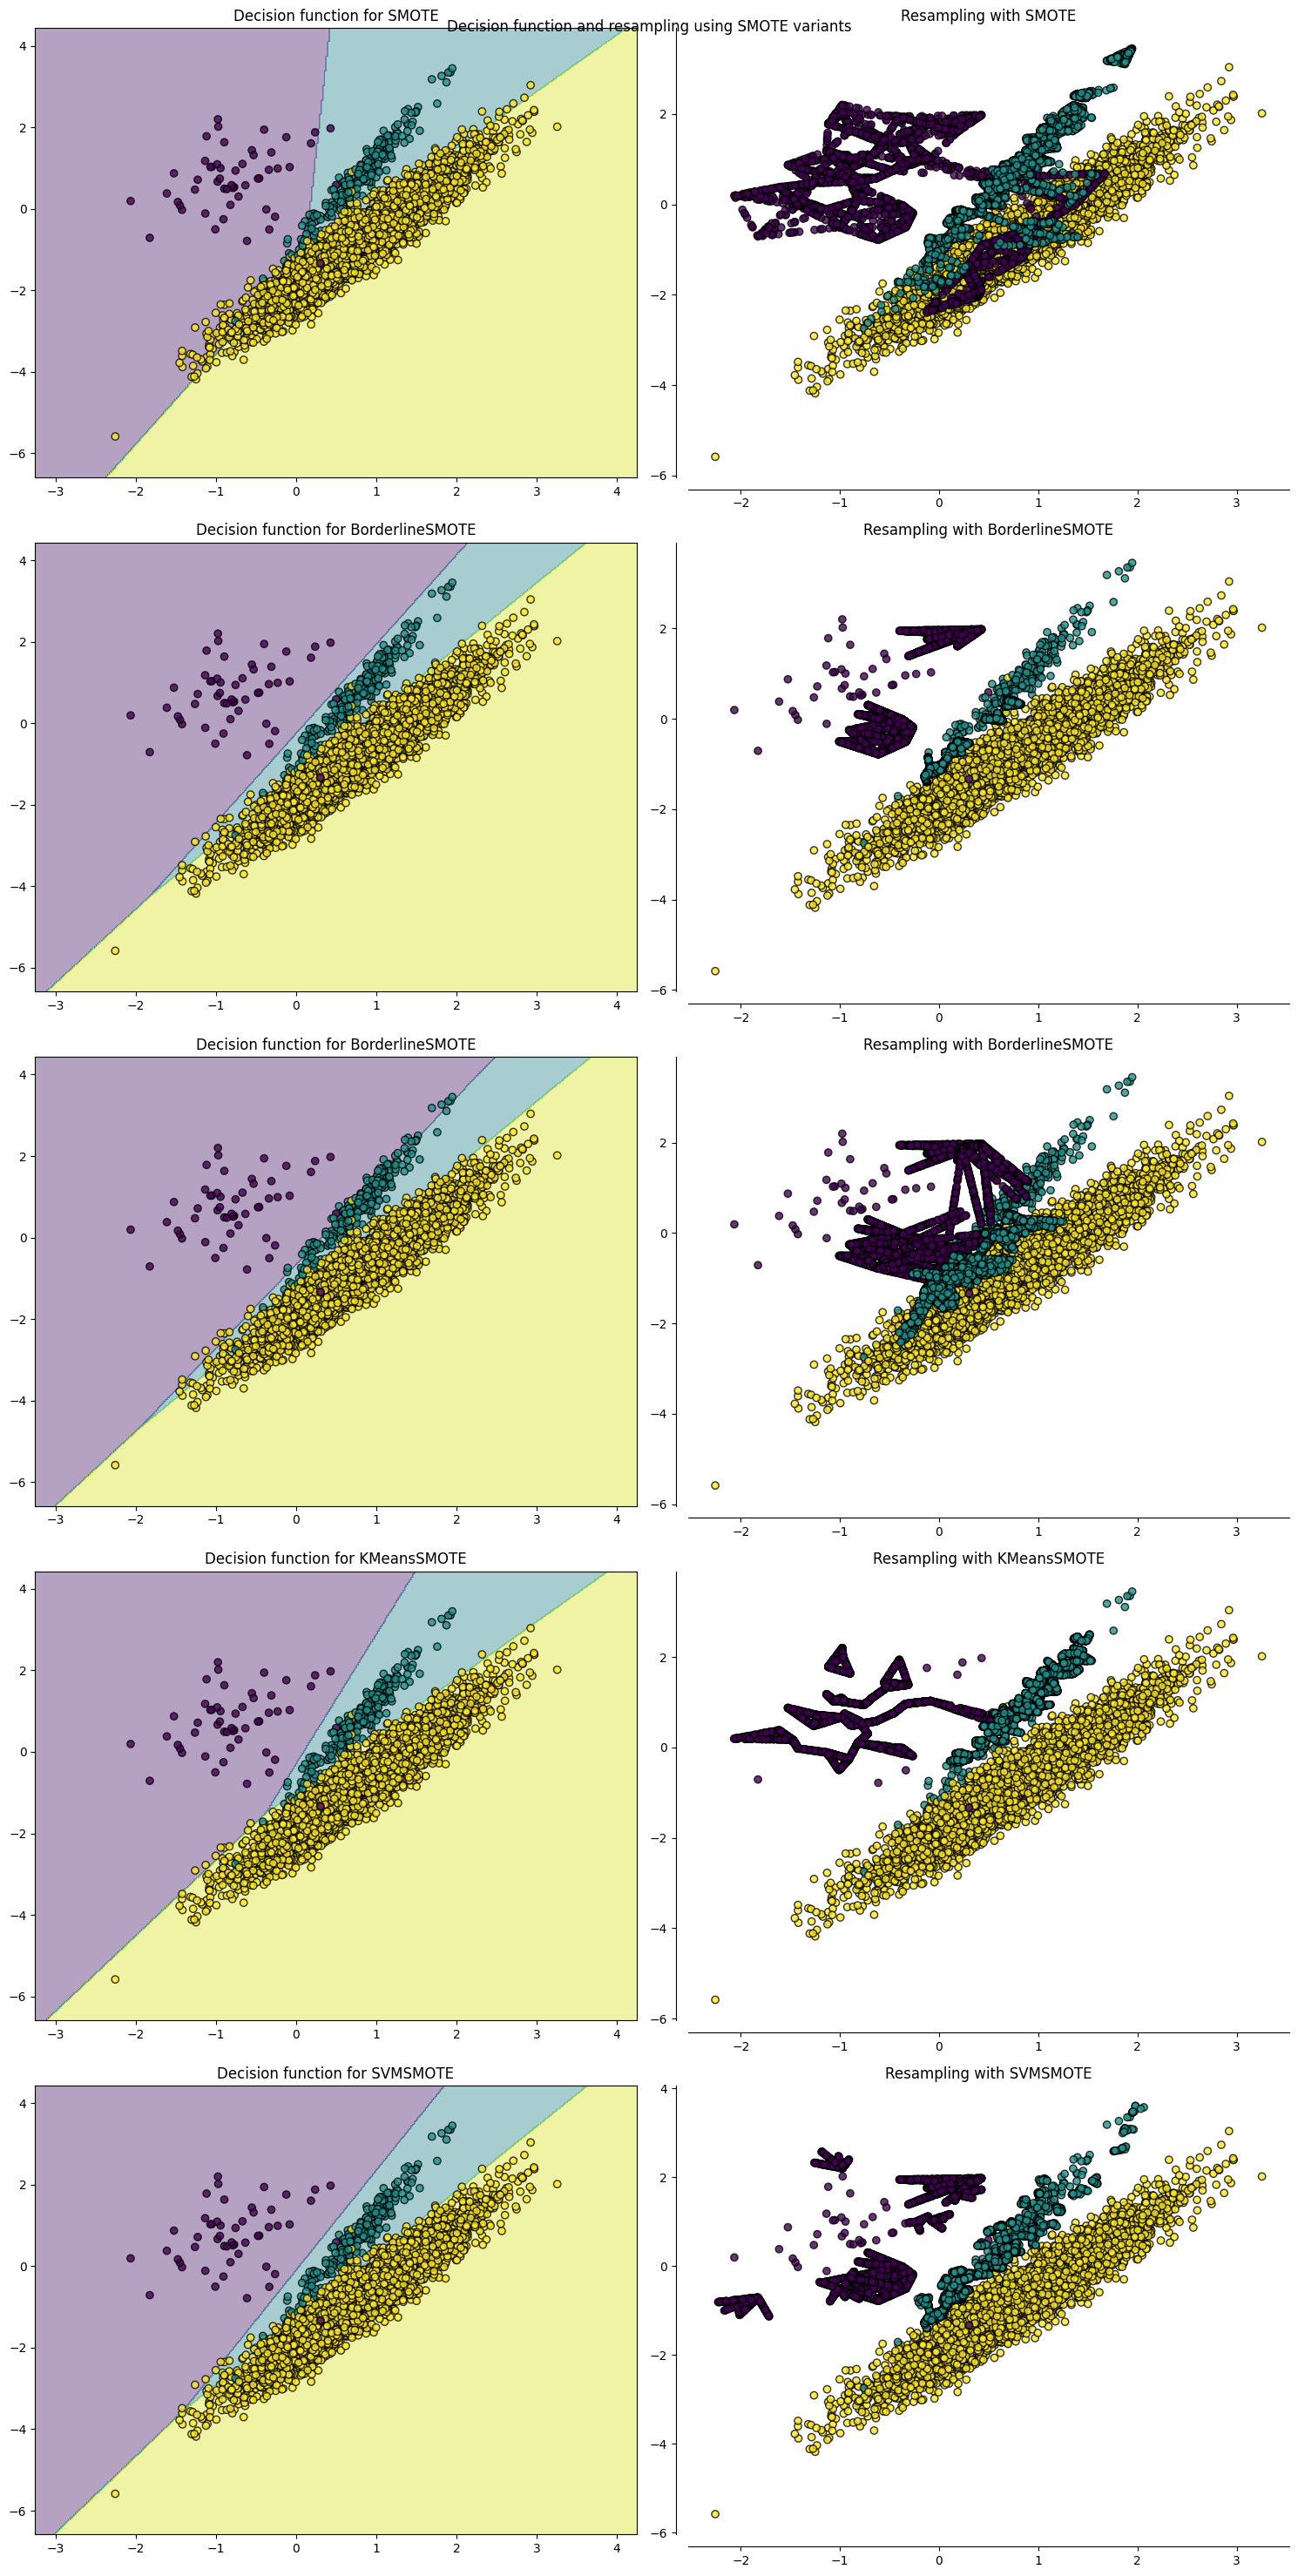

In [15]:
from sklearn.cluster import MiniBatchKMeans

from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE, KMeansSMOTE

X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94), class_sep=0.8)

fig, axs = plt.subplots(5, 2, figsize=(15, 30))

samplers = [
    SMOTE(random_state=0),
    BorderlineSMOTE(random_state=0, kind="borderline-1"),
    BorderlineSMOTE(random_state=0, kind="borderline-2"),
    KMeansSMOTE(
        kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=0
    ),
    SVMSMOTE(random_state=0),
]

for ax, sampler in zip(axs, samplers):
    model = make_pipeline(sampler, clf).fit(X, y)
    plot_decision_function(
        X, y, clf, ax[0], title=f"Decision function for {sampler.__class__.__name__}"
    )
    plot_resampling(X, y, sampler, ax[1])

fig.suptitle("Decision function and resampling using SMOTE variants")
fig.tight_layout()

## PCA-based outliers

Outliers will be the data points that are not well described by the model! Try to find outliers before testing, then test your model.

* $z$ score = $\frac{X_i - \mu}{\sigma}$, $-3< z < +3$, $99.7\%$
* Boxplots (Interquartile range, $IQR = Q3-Q1$; normal range = $(Q1-k*IQR, Q3+k*IQR)$, $k =1.5$ )
* PCA-based
* SVM (see Orange)

[Reference](https://nirpyresearch.com/detecting-outliers-using-mahalanobis-distance-pca-python/)


Remind:
In PCA (Principal Component Analysis) the set of measurements $X$ is transformed into an equivalent set $X’=XW$ by a linear transformation $W$, such that all the new principal componentsare linearly independent. In statistics $X’$ is called the factor scores. The linear transformation in PCA is such that it minimizes the covariance between the different rows of $X’$. That means this process only uses the $X$ data, not the $Y$ values.

### PLS (Partial Least Squares Regression)

PLS is based on finding a similar linear transformation, but accomplishes the same task by maximizing the covariance between $Y$ and $X’$. In other words, PLS takes into account both transformed data and response values and in doing so will improve on some of the limitations on PCA.


In general multivariate PLS, the model is written as:

$X = T \times P^\top + E $

$X = n*m, T = n*k (scores), P^\top = k(loadings)*m, E =n*m$

$n$ samples, $m$ features.

$Y = U×Q^\top +F$

The PLS model is built in such a way to maximize the covariance between $T$ and $U$.

https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html


So to find outliers, we can find data with the largest $E$ (aka Q-residuals), or the largest $T$ (aka Hotelling's T-squared).

Q-residuals account for the variations in the data that are not explained by the model as built. An outlier will have large Q-residual when compared to the corresponding residuals of the other points. Q-residuals are calculated in practice by taking the sum of squares of each row of the error matrix.

T-squared look at the variations within the model itself. Hotelling's T-squared is calculated by summing the squares of the rows of the scores matrix T, after normalising each by its standard deviation.





In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [17]:
# https://www.kaggle.com/rajyellow46/wine-quality

data = pd.read_csv('https://drive.google.com/uc?id=1_5rqomS1sswoR-_MsSPErmTZAJptzPvZ')
Y = data[data.type == 'white']['quality']
X = data[data.type == 'white'].drop(['type','quality'], axis = 1)
X

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5               NaN         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  
0         8.8  
1         9.5  
2        10.1  
3         9.9  
4         9.9  
...       ...  
4893     11.2  
4894      9.6  
4895      9.4  
4896     12.8  
4897     11.8  

[4898 rows x 11 columns]

In [18]:
print(X.isna().sum())
for ser in X:
  X[ser].fillna(value = X[ser].mean(), inplace = True)
print(X.isna().sum())

fixed acidity           8
volatile acidity        7
citric acid             2
residual sugar          2
chlorides               2
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      7
sulphates               2
alcohol                 0
dtype: int64
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


In [19]:
from sklearn.cross_decomposition import PLSRegression
ncomp = 2

# Define PLS object
pls = PLSRegression(n_components = ncomp)
# Fit data
pls.fit(X, Y)
# Get X scores
T = pls.x_scores_
# Get X loadings
P = pls.x_loadings_
# Calculate error array
Err = X - np.dot(T,P.T)
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
# Calculate Hotelling's T-squared (note that data are normalized by default)
Tsq = np.sum((pls.x_scores_/np.std(pls.x_scores_, axis=0))**2, axis=1)

In [20]:
# set the confidence level
conf = 0.95
from scipy.stats import f
# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf = f.ppf(q=conf, dfn = ncomp, dfd = X.shape[0])*ncomp*(X.shape[0]-1)/(X.shape[0]-ncomp)
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0) > conf:
    i -= 1
Q_conf = i

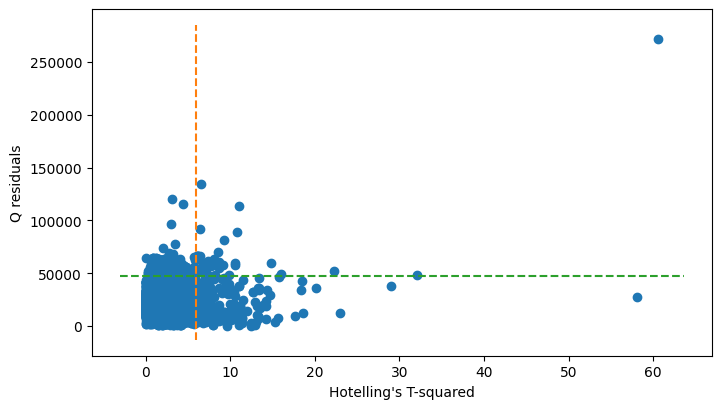

In [21]:
import matplotlib.pyplot as plt
ax = plt.figure(figsize=(8,4.5))

plt.plot(Tsq, Q, 'o')
plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
plt.xlabel("Hotelling's T-squared")
plt.ylabel('Q residuals')
plt.show()

Q: then find the outliers and make a new model using inliers. Does the model improve?

### PCA

Now it’s time to run a PCA decomposition of these data and produce a score plot with the first two principal components.

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
T = pca.fit_transform(StandardScaler().fit_transform(X))

print(pca.explained_variance_ratio_)

[0.29293028 0.14303955 0.11097785 0.09260406 0.08853273 0.08534557
 0.06609423 0.05457406 0.03767632 0.02633155 0.0018938 ]


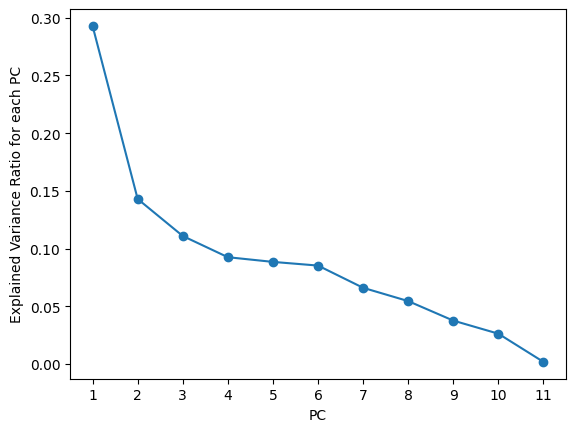

In [23]:
def plotData(plt, data):
  x = [p[0] for p in data]
  y = [p[1] for p in data]
  plt.plot(x, y, '-o')

plotData(plt, list(zip(range(X.shape[1]), pca.explained_variance_ratio_)))
plt.xticks(np.arange(X.shape[1]), np.arange(1, X.shape[1]+1))
plt.xlabel("PC")
plt.ylabel("Explained Variance Ratio for each PC")
plt.show()

<ipython-input-24-79e2dc84348e>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')


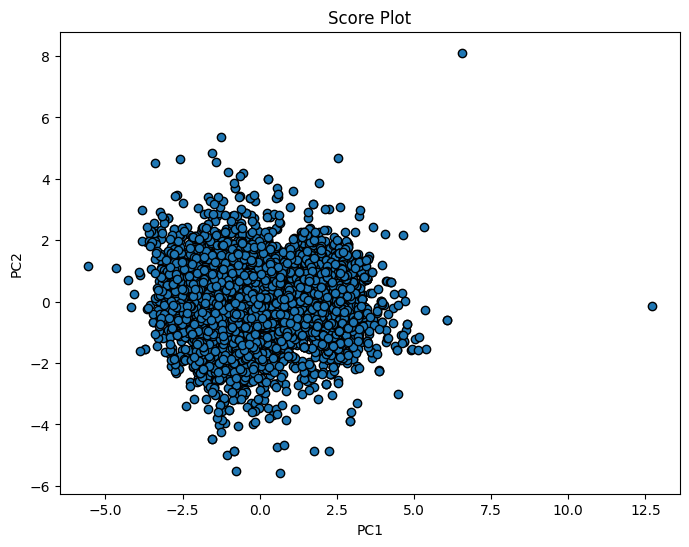

In [24]:
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Score Plot')
plt.show()

Q: Find some way to identify outliers. Make models without outliers. Does the performance of the model imporve?

## Overfit and underfit

Ref: [WillKoehrsen](https://github.com/WillKoehrsen/Data-Analysis/blob/master/over_vs_under/Over%20vs%20Under%20Fitting%20Example.ipynb)



In [25]:
# Set the random seed for reproducible results
np.random.seed(42)

# "True" generating function representing a process in real life
def true_gen(x):
    y = np.sin(1.2 * x * np.pi)
    return(y)

# x values and y value with a small amount of random noise
x = np.sort(np.random.rand(120))
y = true_gen(x) + 0.1 * np.random.randn(len(x))

In [26]:
# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(120)), size = 120, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations
train = xt[:int(0.7 * len(x))]
test = xt[int(0.7 * len(x)):]

y_train = yt[:int(0.7 * len(y))]
y_test = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_gen(x_linspace)

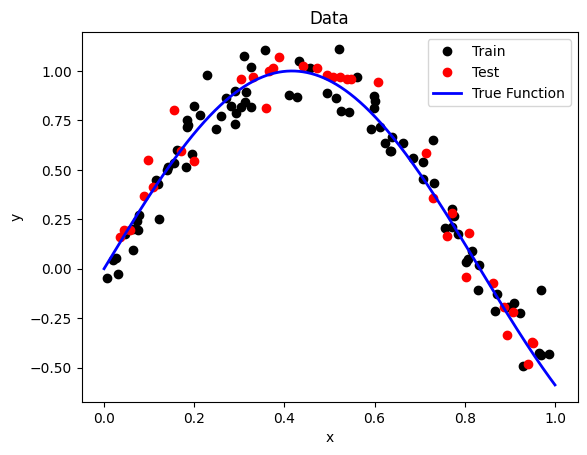

In [27]:
# Visualize observations and true curve
plt.plot(train, y_train, 'ko', label = 'Train');
plt.plot(test, y_test, 'ro', label = 'Test')
plt.plot(x_linspace, y_true, 'b-', linewidth = 2, label = 'True Function')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data');

### Polynomial Model

We want to try and capture the data using a polynomial function. A polynomial is defined by the degree, or the highest power to for the x-values.

A line has a degree of 1 because it is of the form $y = b_1*x + b_0$ where $b_1$ is the slope and $b_0$ is the intercept.

A third degree polynomial would have the form $y = b_3 * x^3 + b_2 * x^2 + b_1 * x + b_0$ and so on. The higher the degree of the polynomial, the more flexible the model.

The following function creates a polynomial with the specified number of degrees and plots the results.

In [28]:
# Scikit-Learn for fitting models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [29]:
def fit_poly(train, y_train, test, y_test, degrees, plot='train', return_scores=False):

    # Create a polynomial transformation of features
    features = PolynomialFeatures(degree=degrees, include_bias=False)

    # Reshape training features for use in scikit-learn and transform features
    train = train.reshape((-1, 1))
    train_trans = features.fit_transform(train)

    # Create the linear regression model and train
    model = LinearRegression()
    model.fit(train_trans, y_train)

    # Calculate the cross validation score
    cross_valid = cross_val_score(model, train_trans, y_train, scoring='neg_mean_squared_error', cv = 5)

    # Training predictions and error
    train_predictions = model.predict(train_trans)
    training_error = mean_squared_error(y_train, train_predictions)

    # Format test features
    test = test.reshape((-1, 1))
    test_trans = features.fit_transform(test)

    # Test set predictions and error
    test_predictions = model.predict(test_trans)
    testing_error = mean_squared_error(y_test, test_predictions)

    # Find the model curve and the true curve
    x_curve = np.linspace(0, 1, 100)
    x_curve = x_curve.reshape((-1, 1))
    x_curve_trans = features.fit_transform(x_curve)

    # Model curve
    model_curve = model.predict(x_curve_trans)

    # True curve
    y_true_curve = true_gen(x_curve[:, 0])

    # Plot observations, true function, and model predicted function
    if plot == 'train':
        plt.plot(train[:, 0], y_train, 'ko', label = 'Observations')
        plt.plot(x_curve[:, 0], y_true_curve, linewidth = 4, label = 'True Function')
        plt.plot(x_curve[:, 0], model_curve, linewidth = 4, label = 'Model Function')
        plt.xlabel('x'); plt.ylabel('y')
        plt.legend()
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.title('{} Degree Model on Training Data'.format(degrees))
        plt.show()

    elif plot == 'test':
        # Plot the test observations and test predictions
        plt.plot(test, y_test, 'o', label = 'Test Observations')
        plt.plot(x_curve[:, 0], y_true_curve, 'b-', linewidth = 2, label = 'True Function')
        plt.plot(test, test_predictions, 'ro', label = 'Test Predictions')
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.legend(), plt.xlabel('x'), plt.ylabel('y'); plt.title('{} Degree Model on Testing Data'.format(degrees)), plt.show();

    # Return the metrics
    if return_scores:
        return training_error, testing_error, -np.mean(cross_valid)

### Underfitting

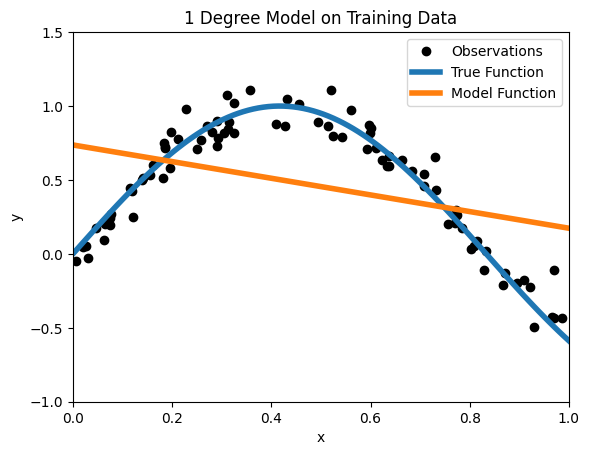

In [30]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='train')

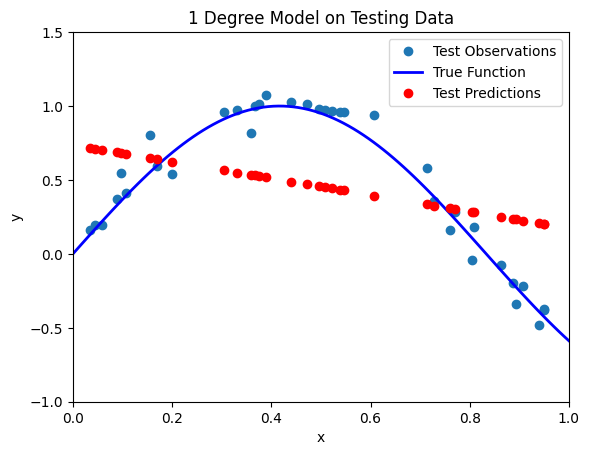

In [31]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='test')

### Overfitting

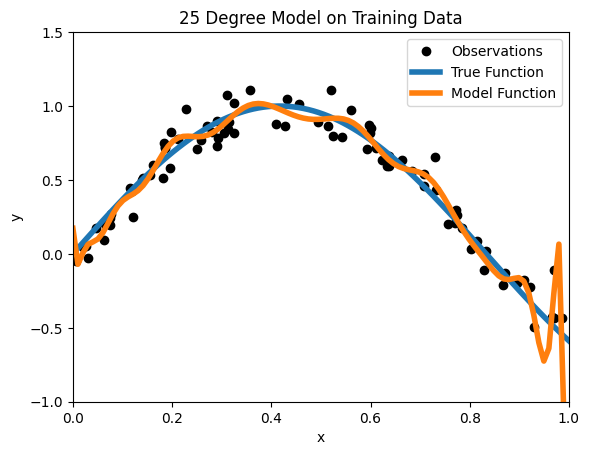

In [32]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 25)

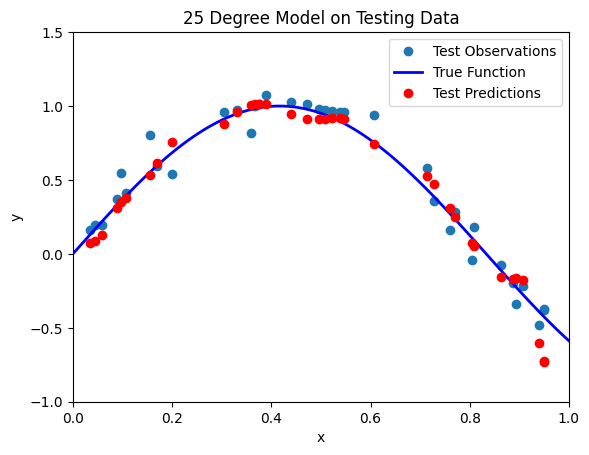

In [33]:
fit_poly(train, y_train, test, y_test, degrees=25, plot='test')

### Balanced Model

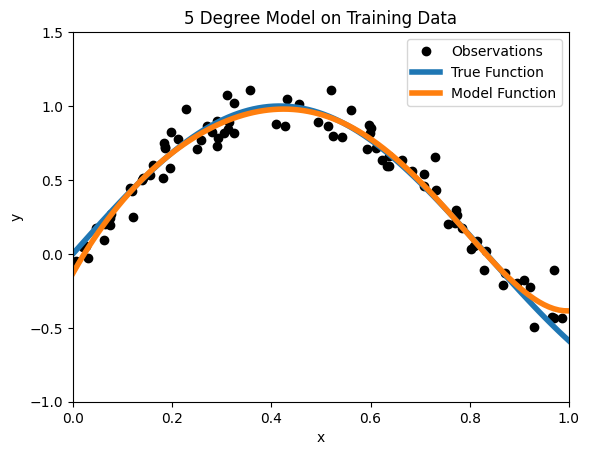

In [34]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 5)

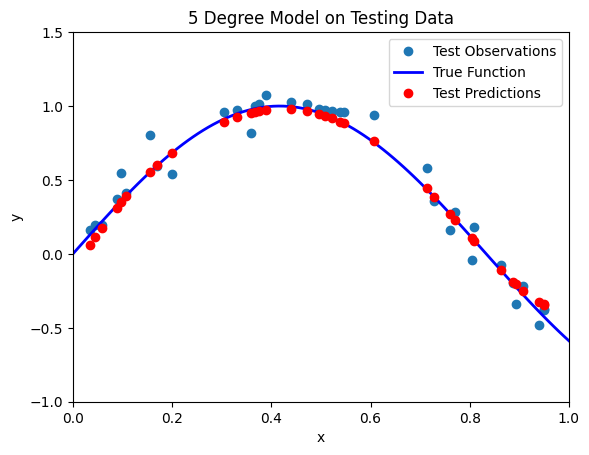

In [35]:
fit_poly(train, y_train, test, y_test, degrees=5, plot='test')

### Validation Dataset

To pick the optimal model, we need to use a validation set. Cross validation is even better than a single validation set because it uses numerous validation sets created from the training data. In this case, we are using 5 different validation sets. The model that performs best on the cross validation is usually the optimal model because it has shown that it can learn the relationships while not overfitting.

In [36]:
# Range of model degrees to evaluate
degrees = [int(x) for x in np.linspace(1, 40, 40)]

# Results dataframe
results = pd.DataFrame(0, columns = ['train_error', 'test_error', 'cross_valid'], index = degrees)

# Try each value of degrees for the model and record results
for degree in degrees:
    degree_results = fit_poly(train, y_train, test, y_test, degree, plot=False, return_scores=True)
    results.loc[degree, 'train_error'] = degree_results[0]
    results.loc[degree, 'test_error'] = degree_results[1]
    results.loc[degree, 'cross_valid'] = degree_results[2]

In [37]:
print('10 Lowest Cross Validation Errors\n')
train_eval = results.sort_values('cross_valid').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'cross_valid']] .head(10)

10 Lowest Cross Validation Errors



degrees  cross_valid
0        4     0.010549
1        5     0.010637
2        7     0.010665
3        6     0.010887
4        8     0.011182
5        3     0.011695
6        9     0.011757
7       11     0.011769
8       10     0.011902
9       12     0.012642

Minimum Cross Validation Error occurs at 3 degrees.



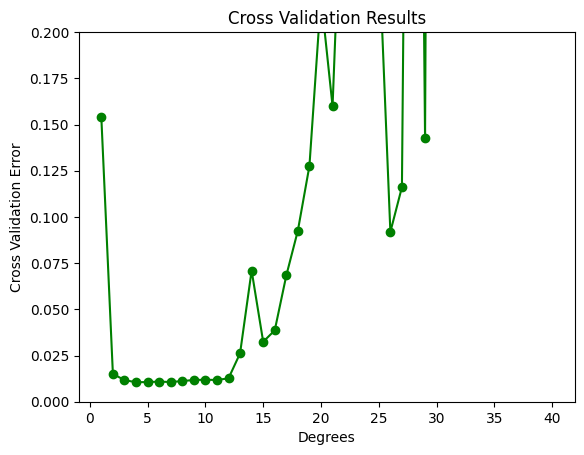

In [38]:
plt.plot(results.index, results['cross_valid'], 'go-', ms=6)
plt.xlabel('Degrees'); plt.ylabel('Cross Validation Error'); plt.title('Cross Validation Results');
plt.ylim(0, 0.2);
print('Minimum Cross Validation Error occurs at {} degrees.\n'.format(int(np.argmin(results['cross_valid']))))

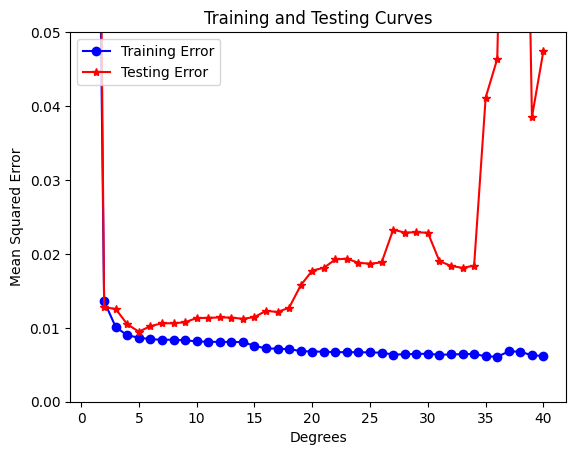


Minimum Training Error occurs at 35 degrees.
Minimum Testing Error occurs at 4 degrees.



In [39]:
plt.plot(results.index, results['train_error'], 'b-o', ms=6, label = 'Training Error')
plt.plot(results.index, results['test_error'], 'r-*', ms=6, label = 'Testing Error')
plt.legend(loc=2); plt.xlabel('Degrees'); plt.ylabel('Mean Squared Error'); plt.title('Training and Testing Curves');
plt.ylim(0, 0.05); plt.show()

print('\nMinimum Training Error occurs at {} degrees.'.format(int(np.argmin(results['train_error']))))
print('Minimum Testing Error occurs at {} degrees.\n'.format(int(np.argmin(results['test_error']))))

Q: if 4 is the magic number, then how do we remove the effectiveness of 5, 6, 7, 8, ...?

### Regularization

* https://towardsdatascience.com/bias-variance-trade-off-with-python-example-6519d2084be4
* https://elitedatascience.com/bias-variance-tradeoff
* https://github.com/ethen8181/machine-learning/blob/master/regularization/regularization.ipynb


#### Bias-Variance tradeoff

Bias-Variance tradeoff: When we discuss prediction models, prediction errors can be decomposed into two main subcomponents we care about: error due to "bias" and error due to "variance". Understanding these two types of error can help us diagnose model results and avoid the mistake of over/under fitting. A typical graph of discussing this is shown below:

* Bias: The red line, measures how far off in general our models' predictions are from the correct value. Thus as our model gets more and more complex we will become more and more accurate about our predictions (Error steadily decreases).

* Variance: The cyan line, measures how different can our model be from one to another, as we're looking at different possible data sets. If the estimated model will vary dramatically from one data set to the other, then we will have very erratic predictions, because our prediction will be extremely sensitive to what data set we obtain. As the complexity of our model rises, variance becomes our primary concern.

Trevor Hastie, Robert Tibshirani, and J H. Friedman, “The Elements of Statistical Learning: Data Mining, Inference, and Prediction”, New York: Springer, 2001.

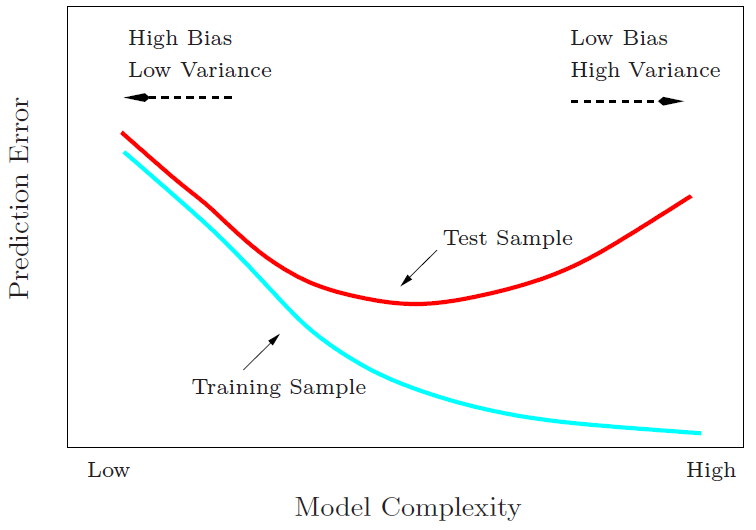




MSE $ = \frac{1}{n} \sum_{i}^{n} (\hat{y_i} - y_i )^2$

$ \theta^* = \arg\min_{\theta^*} \frac{1}{n} \sum_{i}^{n} (f_\theta(x_i) - y_i )^2$

If some variables (for example, $x_j, j \in U$) make the model overfit (as shown in the previous Polynomial Model example, we have too many 'degrees'), could we minimize their factors ($\theta_j$) so that some factors are zeros (hence the degree disapear)?

$ \implies \min [\frac{1}{n} \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \sum_{j \in U} \lambda * \theta_j ]$

where $\lambda$ is a weight/parameter defined by analyzer.

However, we have no idea which variable should be removed! i.e., $U$ is unknown.

$ \implies \min \frac{1}{n} [\sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j}^{m} \theta_j ]$

Q: does it make sense?


The gradient descent now becomes:

$J(\theta) = \frac{1}{2n} [\sum_{i=1}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j=1}^{m} \theta_j ]$


$\theta_j^{t+1} = \theta_j^{t} - \gamma \frac{\partial f(\theta)}{\partial \theta_j}$, ($j$ = $1$ to $m$)

$\theta_j^{t+1} = \theta_j^{t}(1-\gamma\frac{\lambda}{n}) - \gamma\frac{1}{n} [\sum_{i=1}^{n}(f_\theta(x_i) - y_i)*x_{i,j}]$

Note that $(1-\gamma\frac{\lambda}{n})$ is a number that is close to 1.0 but less than 1.0.



#### Ridge and Lasso Regression


Ref: [Ridge and Lasso Regression](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)

**Ridge Regression**: In ridge regression, the cost function is altered by adding a penalty equivalent to **square of the magnitude of the coefficients**.

$ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j}^{m} \theta_j^2 $

or $\frac{1}{2n} \sum(.)^2 + \lambda \sum(.)$ for computation convenient

This is equivalent to saying minimizing the cost function under the condition as below.

$ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 $

$ \sum_{j}^{m} \theta_j^2 < c$, $c>0$

So ridge regression puts constraint on the coefficients ($\theta$). The penalty term ($\lambda$) regularizes the coefficients such that if the coefficients take large values the optimization function is penalized.

So, ridge regression **shrinks the coefficients** and it helps to reduce the model complexity and multi-collinearity.


when $\lambda \to 0$ , the cost function becomes similar to the linear regression cost function. So lower the constraint ($\lambda$) on the features, the model will resemble linear regression model.



**Lasso Regression**: The cost function for Lasso (least absolute shrinkage and selection operator) regression can be written as

$ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j}^{m} |\theta_j| $


This is equivalent to saying minimizing the cost function under the condition as below.

$ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 $

$ \sum_{j}^{m} |\theta_j| < t$, $t>0$

The only difference is instead of taking the square of the coefficients (L2), magnitudes are taken into account. This type of regularization (L1) **can lead to zero coefficients** i.e. some of the features are completely neglected for the evaluation of output.

So Lasso regression not only helps in reducing over-fitting but it can help us in **feature selection**.

**Why** Lasso can do feature selection (lead to zero), by Ridge can only make coefficients to approach to zero (but not exact zero)?


For one coefficient (a $\theta_j$) in **Ridge**, to solve this equation only for one $\theta_j$ for now and latter you can generalize this:

$ (y - \theta x)^2 + \lambda \theta^2 $

The goal is to minimize the above equation, to be able to do this, will equate this to zero and take the derivatives w.r.t

$ y^2 - 2xy\theta + \theta^2 x^2 + \lambda \theta^2$

Partial derivatives w.r.t $\theta$

$ - 2xy + 2 \theta x^2 + 2 \lambda \theta = 0$

$ \theta = \frac{xy}{x^2 + \lambda}$

If $\lambda \rightarrow \infty$, $\theta$ will be small, but will not be zero because $x^2$ exists.


For one coefficient (a $\theta_j$) in **LASSO**:

$ (y - \theta x)^2 + \lambda \theta $

Take the derivatives w.r.t

$ y^2 - 2xy\theta + \theta^2 x^2 + \lambda \theta$

Partial derivatives w.r.t $\theta$

$ - 2xy + 2 \theta x^2 +\lambda = 0$

$ \theta = \frac{2xy - \lambda}{2 x^2}$

If $\lambda \rightarrow \infty$, $\theta$ will lead to zero.

#### A simple example

A linear model $y = f_\theta(x_i) =\theta_1 * x_i + \theta_0$ is used.

$ \text{MSE} = \frac{1}{n} \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 = \frac{1}{n}\sum_{i=1}^{n}{x_{i}^{2}\theta_{1}^{2} + \theta_{0}^{2} + 2 x_i \theta_1 \theta_0 - 2 x_{i} y_{i} \theta_1 - 2 y_i \theta_0  + y_{i}^{2} }$

$ \theta^* = \arg\min_{\theta^*} \frac{1}{n} \sum_{i}^{n} (f_\theta(x_i) - y_i )^2$

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the random seed for reproducible results
np.random.seed(42)

def true_gen(x):
    y = 1.2 * x + 0.7
    return(y)

# x values and y value with a small amount of random noise
n = 120
x = np.sort(np.random.rand(n))
y = true_gen(x) + 0.1 * np.random.randn(len(x))

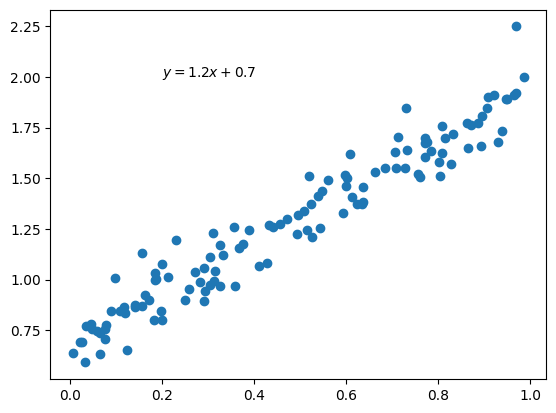

In [41]:
plt.text(0.2, 2, "$y = 1.2 x + 0.7$")
plt.scatter(x,y)
plt.show()

In [42]:
from sklearn.linear_model import Lasso, Ridge
reg = Lasso(alpha = 0) # 0 = linear regression
reg.fit(x.reshape(-1, 1), y.reshape(-1, 1))
linear_b0 = reg.intercept_[0]
linear_b1 = reg.coef_[0]
print("linear:", linear_b0, linear_b1)
print("sum of factors:", linear_b0+linear_b1)

linear: 0.6833980390205721 1.2479242347440573
sum of factors: 1.9313222737646294


<ipython-input-42-38642496f2e7>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(x.reshape(-1, 1), y.reshape(-1, 1))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.653e-01, tolerance: 1.757e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [43]:
reg = Lasso(alpha = 0.05) # <------ Try this !!!
reg.fit(x.reshape(-1, 1), y.reshape(-1, 1))
lasso_b0 = reg.intercept_[0]
lasso_b1 = reg.coef_[0]
print("lasso: ", lasso_b0, lasso_b1)
print("sum of factors:", lasso_b0+lasso_b1)

lasso:  0.9545993668479892 0.6794991739957256
sum of factors: 1.6340985408437148


In [44]:
reg2 = Ridge(alpha = 0.05) # <------ Try this !!!
reg2.fit(x.reshape(-1, 1), y.reshape(-1, 1))
ridge_b0 = reg2.intercept_[0]
ridge_b1 = reg2.coef_[0][0]
print("ridge: ", ridge_b0, ridge_b1)
print("sum of factors:", ridge_b0+lasso_b1)

ridge:  0.6862050650667373 1.2420408419023048
sum of factors: 1.3657042390624627


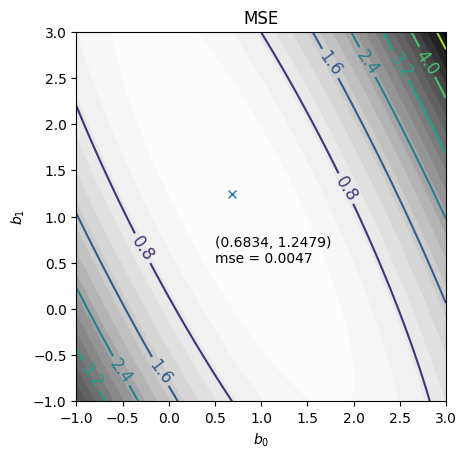

In [45]:
def mse(b0, b1):
    global x,y
    mse = 0
    for xi,yi in zip(x,y):
        mse += xi*xi*b1*b1 + b0*b0 + 2*xi*b1*b0 -2*xi*yi*b1 - 2*yi*b0 + yi*yi
    mse = mse/(2*len(x)) # use 1/2n version
    return mse

# mesh
grid = 100
b0_range = np.linspace(-1, 3, grid)
b1_range = np.linspace(-1, 3, grid)
B0, B1 = np.meshgrid(b0_range, b1_range)

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# contour
plt.contourf(B0, B1, mse(B0, B1), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, mse(B0, B1)) # line
plt.clabel(C, inline=True, fontsize=12)

# point
plt.plot([linear_b0],[linear_b1], 'x')
plt.text(0.5, 0.5, "({:.4f}, {:.4f})\nmse = {:.4f}".format(
    linear_b0, linear_b1, mse(linear_b0, linear_b1) ))

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('MSE')
plt.show()

Lasso: $ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j}^{m} |\theta_j| $

Ridge: $ \sum_{i}^{n} (f_\theta(x_i) - y_i )^2 + \lambda \sum_{j}^{m} \theta_j^2 $

In [46]:
def lasso(b0, b1, l):
    global x,y
    mse = 0
    for xi,yi in zip(x,y):
        mse += xi*xi*b1*b1 + b0*b0 + 2*xi*b1*b0 -2*xi*yi*b1 - 2*yi*b0 + yi*yi
    lasso = mse/(2*len(x)) + l * (abs(b0) + abs(b1))
    return lasso

def ridge(b0, b1, l):
    global x,y
    mse = 0
    for xi,yi in zip(x,y):
        mse += xi*xi*b1*b1 + b0*b0 + 2*xi*b1*b0 -2*xi*yi*b1 - 2*yi*b0 + yi*yi
    ridge = mse + l * (b0*b0 + b1*b1)
    return ridge

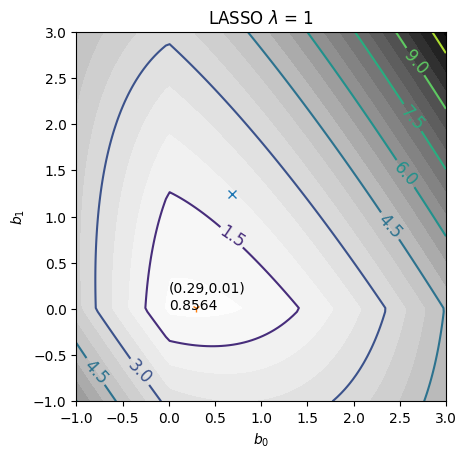

In [47]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# lambda
L = 1 # <---------------- Try 0, 1, 0.x, 99?

# contour
plt.contourf(B0, B1, lasso(B0, B1, L), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, lasso(B0, B1, L)) # line
plt.clabel(C, inline=True, fontsize=12)

# orig point
plt.plot([linear_b0],[linear_b1], 'x') # orig point

# lasso point
l = np.matrix([lasso(b0,b1,L) for b0, b1 in zip(B0, B1)])
(lasso_b1_idx, lasso_b0_idx) = np.unravel_index(l.argmin(), l.shape)
lasso_b0 = b0_range[lasso_b0_idx]
lasso_b1 = b1_range[lasso_b1_idx]

plt.plot([lasso_b0],[lasso_b1], '1') # lasso point
plt.text(0.0,0.0, '({:.2f},{:.2f})\n{:.4f}'.format(lasso_b0, lasso_b1, l.min())) # lasso point

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('LASSO $\lambda$ = {}'.format(L))
plt.show()

If lasso used, the $(b_0, b_1)$ point move toward zero point. The shape of loss function changes, too.

Try to make $L$ be a very large number! Then, we do not care about MSE, we only want the $(b_0, b_1)$ as close to zero point as possible. We can observe a 'contrain' on the graph, and it looks like a reverse Pyramid (whose outer surfaces are triangular and converge to a single point at the bottom at (0,0)).

If $L = |b_0| + |b_1|$,

Question: why the smallest lasso is not at (0,0)?

In [48]:
lasso(0, 0, 1e20)

0.8908619343461633

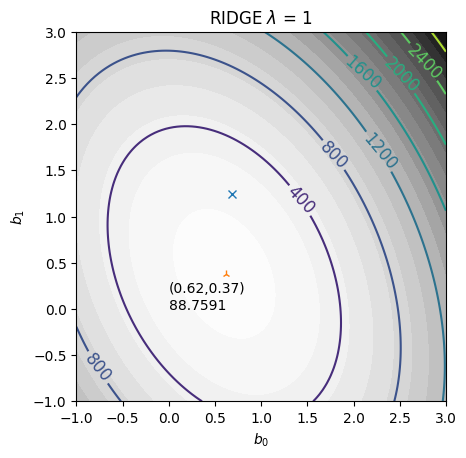

In [49]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# lambda
R = 99 # <---------------- Try 0, 1, 0.x, 99?

# contour
plt.contourf(B0, B1, ridge(B0, B1, R), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, ridge(B0, B1, R)) # line
plt.clabel(C, inline=True, fontsize=12)

# orig point
plt.plot([linear_b0],[linear_b1], 'x') # orig point

# ridge point
r = np.matrix([ridge(b0,b1,R) for b0, b1 in zip(B0, B1)])
(ridge_b1_idx, ridge_b0_idx) = np.unravel_index(r.argmin(), r.shape)
ridge_b0 = b0_range[ridge_b0_idx]
ridge_b1 = b1_range[ridge_b1_idx]

plt.plot([ridge_b0],[ridge_b1], '2') # ridge point
plt.text(0.0,0.0, '({:.2f},{:.2f})\n{:.4f}'.format(ridge_b0, ridge_b1, r.min())) # ridge point

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('RIDGE $\lambda$ = {}'.format(L))
plt.show()

In [50]:
ridge(0.0, 0.0, 99)

213.8068642430792

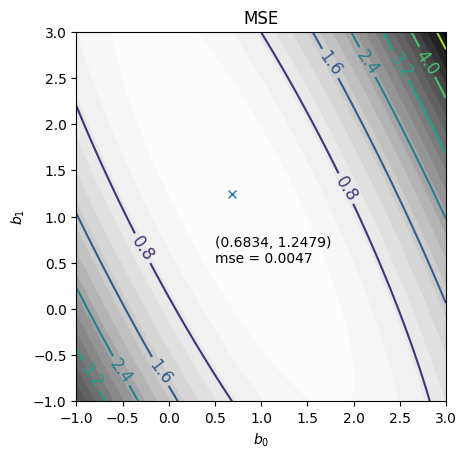

In [51]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# contour
plt.contourf(B0, B1, mse(B0, B1), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, mse(B0, B1)) # line
plt.clabel(C, inline=True, fontsize=12)

# point
plt.plot([linear_b0],[linear_b1], 'x')
plt.text(0.5, 0.5, "({:.4f}, {:.4f})\nmse = {:.4f}".format(
    linear_b0, linear_b1, mse(linear_b0, linear_b1) ))

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('MSE')
plt.show()

We often see this figure when lasso and ridge are discussed.

J. Dong, et al., "Quality monitoring and root cause diagnosis for industrial processes based on Lasso-SAE-CCA," IEEE Access, DOI: 10.1109/ACCESS.2019.2926067.

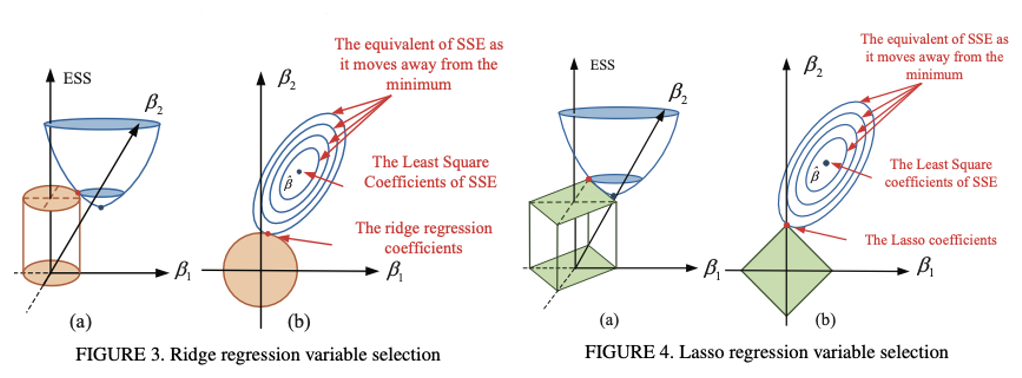

#### Cancer Example

In [52]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [53]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df.head(3)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33            184.6   
1                 0.05667  ...         24.99          23.41            158.8   
2                 0.05999  ...         23.57          25.53            152.5   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  

[3 rows x 30 columns]

In [54]:
X = cancer.data
Y = cancer.target
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)

In [55]:
# Read this first!!!
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

lasso = Lasso() # alpha=1.0
lasso.fit(X_train,y_train)

train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.5600974529893081
test score:  0.5832244618818156
number of features used:  4


In [56]:
lasso001 = Lasso(alpha=0.01, max_iter=1000000)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print("training score for alpha=0.01:", train_score001)
print("test score for alpha =0.01: ", test_score001)
print("number of features used for alpha=0.01:", coeff_used001)

training score for alpha=0.01: 0.7037865778498826
test score for alpha =0.01:  0.6641831577726228
number of features used for alpha=0.01: 10


In [57]:
lasso00001 = Lasso(alpha=0.0001, max_iter=1000000)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print("training score for alpha=0.0001:", train_score00001)
print("test score for alpha =0.0001: ", test_score00001)
print("number of features used for alpha=0.0001:", coeff_used00001)

training score for alpha=0.0001: 0.7754092006936698
test score for alpha =0.0001:  0.7318608210757908
number of features used for alpha=0.0001: 22


In [58]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

print("LR training score:", lr_train_score)
print("LR test score: ", lr_test_score)

LR training score: 0.784220619405507
LR test score:  0.7329325010888674


Question: Lasso uses only 4 features, but the acuracy is quite low. What happened?

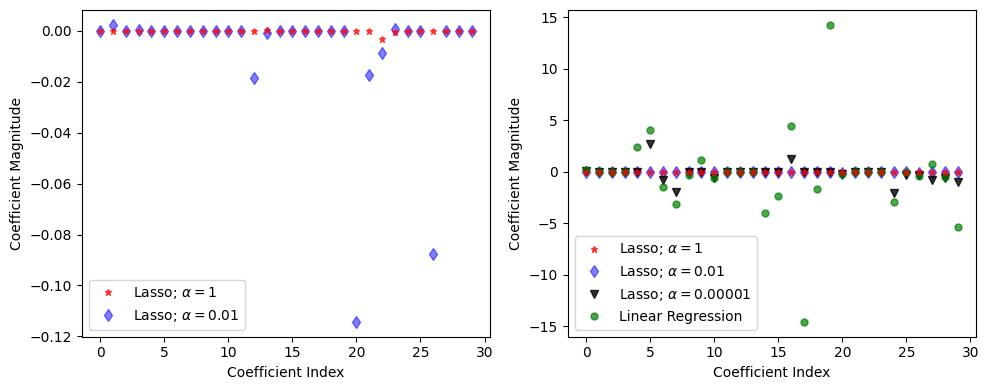

In [59]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=3)

plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=3)

plt.tight_layout()
plt.show()

Question: how do you find the best $\lambda$?